In [1]:
import pandas as pd
import numpy as np
import pickle as pkl
import random
import torchaudio

random.seed(0)
np.random.seed(0)

In [2]:
!nvidia-smi

Tue Jul 18 17:12:06 2023       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.54.03              Driver Version: 535.54.03    CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  NVIDIA GeForce RTX 3090        Off | 00000000:01:00.0  On |                  N/A |
| 38%   62C    P0             152W / 350W |    705MiB / 24576MiB |      6%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

## Load GoEmotions and General Audio Datasets (CREMA, TESS,  RAVDASS, ETC)

In [3]:
train_audio = pkl.load(open('/home/vmachado/Documents/c4ai_clip_audio_text/data/c4ai_clip/train_audio.pkl', "rb"))[['path', 'label']]
test_audio = pkl.load(open('/home/vmachado/Documents/c4ai_clip_audio_text/data/c4ai_clip/test_audio.pkl', "rb"))[['path', 'label']]
train_text = pkl.load(open('/home/vmachado/Documents/c4ai_clip_audio_text/data/c4ai_clip/train_text.pkl', "rb"))[['text', 'grouped_label']]
test_text = pkl.load(open('/home/vmachado/Documents/c4ai_clip_audio_text/data/c4ai_clip/test_text.pkl', "rb"))[['text', 'grouped_label']]

In [4]:
go_emotions = pd.concat([train_text, test_text])

In [5]:
go_emotions.groupby("grouped_label").count()

text
grouped_label       
anger           6039
disgust          664
fear             705
joy            19002
neutral        14429
sadness         2936
surprise        5062

In [6]:
anger = go_emotions[go_emotions["grouped_label"] == "anger"].sample(5000, replace=False, random_state=0)
disgust = go_emotions[go_emotions["grouped_label"] == "disgust"].sample(4000, replace=True, random_state=0)
fear = go_emotions[go_emotions["grouped_label"] == "fear"].sample(4000, replace=True, random_state=0)
joy = go_emotions[go_emotions["grouped_label"] == "joy"].sample(5000, replace=False, random_state=0)
neutral = go_emotions[go_emotions["grouped_label"] == "neutral"].sample(5000, replace=False, random_state=0)
sadness = go_emotions[go_emotions["grouped_label"] == "sadness"].sample(2000, replace=True, random_state=0)

In [7]:
go_emotions = go_emotions[go_emotions["grouped_label"] != "anger"]
go_emotions = go_emotions[go_emotions["grouped_label"] != "joy"]
go_emotions = go_emotions[go_emotions["grouped_label"] != "neutral"]
go_emotions = pd.concat([go_emotions, anger, disgust, fear, joy, neutral, sadness])
go_emotions.groupby("grouped_label").count()

text
grouped_label      
anger          5000
disgust        4664
fear           4705
joy            5000
neutral        5000
sadness        4936
surprise       5062

In [8]:
def norm_labels(x):
    if x == "afraid":
        return "fear"
    elif x == "angry":
        return "anger"
    elif x == "disgusted":
        return "disgust"
    elif x == "sad":
        return "sadness"
    else:
        return x

In [9]:
train_audio["label"] = train_audio["label"].apply(norm_labels)
test_audio["label"] = test_audio["label"].apply(norm_labels)

In [10]:
pd.concat([train_audio,test_audio]).groupby("label").count()

path
label         
anger     1863
disgust   1863
fear      1863
joy       2055
neutral   1583
sadness   1863
surprise   592

In [11]:
audio_datasets = pd.concat([train_audio,test_audio]).reset_index(drop=True)

In [12]:
surprise = audio_datasets[audio_datasets["label"] == "surprise"].sample(2000, replace=True, random_state=0)
audio_datasets = audio_datasets[audio_datasets["label"] != "surprise"]
audio_datasets = pd.concat([audio_datasets, surprise]).reset_index(drop=True)
#audio_datasets

In [13]:
audio_datasets.groupby("label").count()

path
label         
anger     1863
disgust   1863
fear      1863
joy       2055
neutral   1583
sadness   1863
surprise  2000

## Load Meld and IEMOCAP

In [14]:
train_df_erc = pd.read_csv("train_text_df.csv", index_col=0).rename(columns={"utterance":"text"})
train_df_erc["path"] = train_df_erc["path"].apply(lambda x: '/home/vmachado/Documents/' + x)
train_df_erc

text     label  \
0      The only one I know still love his parents. [B...       joy   
1      The only one I know still love his parents. Ye...   neutral   
2      Oh it's not bad thing it's good thing. You kno...       joy   
3      You know it's nice here, the air is sweet. You...   sadness   
4      You're not sorry you came? Not sorry, no.  I c...   sadness   
...                                                  ...       ...   
13723  That would be no. Come on. It doesn't taste ba...   neutral   
13724  Come on. It doesn't taste bad. Yeah, it's kind...       joy   
13725  Yeah, it's kinda sweet, sorta like, uh... Cant...   neutral   
13726  Cantaloupe juice. Exactly. [BFR] You've tasted...  surprise   
13727  Exactly. You've tasted it? You've tasted it. [...   neutral   

                                                    path  
0      /home/vmachado/Documents/multimodal-datasets/I...  
1      /home/vmachado/Documents/multimodal-datasets/I...  
2      /home/vmachado/Documents/multimodal-datasets/I...  
3      /home/vmachado/Documents/multimodal-datasets/I...  
4      /home/vmachado/Documents/multimodal-datasets/I...  
...                                                  ...  
13723  /home/vmachado/Documents/multimodal-datasets/M...  
13724  /home/vmachado/Documents/multimodal-datasets/M...  
13725  /home/vmachado/Documents/multimodal-datasets/M...  
13726  /home/vmachado/Documents/multimodal-datasets/M...  
13727  /home/vmachado/Documents/multimodal-datasets/M...  

[13728 rows x 3 columns]

In [15]:
test_df_erc = pd.read_csv("test_text_df.csv", index_col=0).rename(columns={"utterance":"text"})
test_df_erc["path"] = test_df_erc["path"].apply(lambda x: '/home/vmachado/Documents/' + x)
test_df_erc

text    label  \
0      [BFR] Brian, I need help. [AFT] Babe, I don't...  sadness   
1     Brian, I need help. [BFR] Babe, I don't know w...  neutral   
2     Babe, I don't know what to tell you.  Don't gi...  neutral   
3     I wish I had some answers for you, babe.  I me...  neutral   
4     I went to school and I got my degree.  And I g...  neutral   
...                                                 ...      ...   
3846     Oh, it is. It isn't. [BFR] It is. [AFT] Isn't!  neutral   
3847               It isn't. It is. [BFR] Isn't! [AFT]     anger   
3848   [BFR] Yeah baby! [AFT] I’m really glad you gu...      joy   
3849  Yeah baby! [BFR] I’m really glad you guys are ...  neutral   
3850                                               Hey.  neutral   

                                                   path  
0     /home/vmachado/Documents/multimodal-datasets/I...  
1     /home/vmachado/Documents/multimodal-datasets/I...  
2     /home/vmachado/Documents/multimodal-datasets/I...  
3     /home/vmachado/Documents/multimodal-datasets/I...  
4     /home/vmachado/Documents/multimodal-datasets/I...  
...                                                 ...  
3846  /home/vmachado/Documents/multimodal-datasets/M...  
3847  /home/vmachado/Documents/multimodal-datasets/M...  
3848  /home/vmachado/Documents/multimodal-datasets/M...  
3849  /home/vmachado/Documents/multimodal-datasets/M...  
3850  /home/vmachado/Documents/multimodal-datasets/M...  

[3851 rows x 3 columns]

In [16]:
test_df_erc["source"] = test_df_erc["path"].apply(lambda x: "meld" if "MELD" in x else "iemocap")
test_df_erc

text    label  \
0      [BFR] Brian, I need help. [AFT] Babe, I don't...  sadness   
1     Brian, I need help. [BFR] Babe, I don't know w...  neutral   
2     Babe, I don't know what to tell you.  Don't gi...  neutral   
3     I wish I had some answers for you, babe.  I me...  neutral   
4     I went to school and I got my degree.  And I g...  neutral   
...                                                 ...      ...   
3846     Oh, it is. It isn't. [BFR] It is. [AFT] Isn't!  neutral   
3847               It isn't. It is. [BFR] Isn't! [AFT]     anger   
3848   [BFR] Yeah baby! [AFT] I’m really glad you gu...      joy   
3849  Yeah baby! [BFR] I’m really glad you guys are ...  neutral   
3850                                               Hey.  neutral   

                                                   path   source  
0     /home/vmachado/Documents/multimodal-datasets/I...  iemocap  
1     /home/vmachado/Documents/multimodal-datasets/I...  iemocap  
2     /home/vmachado/Documents/multimodal-datasets/I...  iemocap  
3     /home/vmachado/Documents/multimodal-datasets/I...  iemocap  
4     /home/vmachado/Documents/multimodal-datasets/I...  iemocap  
...                                                 ...      ...  
3846  /home/vmachado/Documents/multimodal-datasets/M...     meld  
3847  /home/vmachado/Documents/multimodal-datasets/M...     meld  
3848  /home/vmachado/Documents/multimodal-datasets/M...     meld  
3849  /home/vmachado/Documents/multimodal-datasets/M...     meld  
3850  /home/vmachado/Documents/multimodal-datasets/M...     meld  

[3851 rows x 4 columns]

In [17]:
test_df_erc.groupby("source").count()

text  label  path
source                    
iemocap  1241   1241  1241
meld     2610   2610  2610

## Join datasets

In [18]:
train_df_erc.groupby("label").count()

text  path
label               
anger     1954  1954
disgust    258   258
fear       266   266
joy       2783  2783
neutral   5804  5804
sadness   1451  1451
surprise  1212  1212

In [19]:
ang = train_df_erc[train_df_erc["label"] == "anger"].sample(3000, replace=True, random_state=0)
disg = train_df_erc[train_df_erc["label"] == "disgust"].sample(4700, replace=True, random_state=0)
fear = train_df_erc[train_df_erc["label"] == "fear"].sample(4700, replace=True, random_state=0)
joy = train_df_erc[train_df_erc["label"] == "joy"].sample(2300, replace=True, random_state=0)
sadness = train_df_erc[train_df_erc["label"] == "sadness"].sample(3500, replace=True, random_state=0)
surprise = train_df_erc[train_df_erc["label"] == "surprise"].sample(3800, replace=True, random_state=0)

In [20]:
train_df_erc_resampled = pd.concat([train_df_erc, joy, ang, disg, fear, surprise, sadness]).reset_index(drop=True)

In [21]:
train_df_erc_resampled = train_df_erc

In [22]:
train_df_erc_resampled.groupby("label").count()

text  path
label               
anger     1954  1954
disgust    258   258
fear       266   266
joy       2783  2783
neutral   5804  5804
sadness   1451  1451
surprise  1212  1212

## VoxPopuli + VoxCeleb

In [23]:
df_vox = pd.read_csv("voxceleb.csv").drop(columns="Unnamed: 0")[["path", "text", "sentiment_label"]]
df_vox

path  \
0     /home/vmachado/.cache/huggingface/datasets/dow...   
1     /home/vmachado/.cache/huggingface/datasets/dow...   
2     /home/vmachado/.cache/huggingface/datasets/dow...   
3     /home/vmachado/.cache/huggingface/datasets/dow...   
4     /home/vmachado/.cache/huggingface/datasets/dow...   
...                                                 ...   
7161  /home/vmachado/.cache/huggingface/datasets/dow...   
7162  /home/vmachado/.cache/huggingface/datasets/dow...   
7163  /home/vmachado/.cache/huggingface/datasets/dow...   
7164  /home/vmachado/.cache/huggingface/datasets/dow...   
7165  /home/vmachado/.cache/huggingface/datasets/dow...   

                                                   text sentiment_label  
0     and i i don't believe in god no religion says ...         Neutral  
1     the question because of my mother till i was f...         Neutral  
2     from my own culture things changed i i think a...         Neutral  
3         of god what is a creator the almighty that uh         Neutral  
4     i don't wanna pinpoint what exactly god is i i...         Neutral  
...                                                 ...             ...  
7161  the movie while he's solving this mystery exce...         Neutral  
7162  in my backstory you know that i actually uh hi...         Neutral  
7163       and it's just high action uh uh you want you         Neutral  
7164  you you can't stop thinking and and wondering ...         Neutral  
7165  and very flattering it's you know because i gr...         Neutral  

[7166 rows x 3 columns]

In [24]:
df_ls = pd.read_csv("voxceleb.csv").drop(columns="Unnamed: 0")[["path", "text", "sentiment_label"]] #pd.read_csv("df_ls.csv")
df_ls

path  \
0     /home/vmachado/.cache/huggingface/datasets/dow...   
1     /home/vmachado/.cache/huggingface/datasets/dow...   
2     /home/vmachado/.cache/huggingface/datasets/dow...   
3     /home/vmachado/.cache/huggingface/datasets/dow...   
4     /home/vmachado/.cache/huggingface/datasets/dow...   
...                                                 ...   
7161  /home/vmachado/.cache/huggingface/datasets/dow...   
7162  /home/vmachado/.cache/huggingface/datasets/dow...   
7163  /home/vmachado/.cache/huggingface/datasets/dow...   
7164  /home/vmachado/.cache/huggingface/datasets/dow...   
7165  /home/vmachado/.cache/huggingface/datasets/dow...   

                                                   text sentiment_label  
0     and i i don't believe in god no religion says ...         Neutral  
1     the question because of my mother till i was f...         Neutral  
2     from my own culture things changed i i think a...         Neutral  
3         of god what is a creator the almighty that uh         Neutral  
4     i don't wanna pinpoint what exactly god is i i...         Neutral  
...                                                 ...             ...  
7161  the movie while he's solving this mystery exce...         Neutral  
7162  in my backstory you know that i actually uh hi...         Neutral  
7163       and it's just high action uh uh you want you         Neutral  
7164  you you can't stop thinking and and wondering ...         Neutral  
7165  and very flattering it's you know because i gr...         Neutral  

[7166 rows x 3 columns]

## Join all datasets

In [25]:
#df_train = pd.concat([go_emotions.rename(columns={"grouped_label":"label"}).assign(path=[None for _ in range(len(go_emotions))]), audio_datasets.assign(text=[None for _ in range(len(audio_datasets))]), train_df_erc_resampled, df_ls]).reset_index(drop=True) #.drop(columns="path")
#df_train = pd.concat([audio_datasets.assign(text=[None for _ in range(len(audio_datasets))]), train_df_erc_resampled,train_df_erc_resampled, df_ls]).reset_index(drop=True) #.drop(columns="path")
df_train = pd.concat([go_emotions.rename(columns={"grouped_label":"label"}).assign(path=[None for _ in range(len(go_emotions))]), train_df_erc_resampled, df_ls, audio_datasets]).reset_index(drop=True)
df_train

text     label  \
0                            To make her feel threatened      fear   
1      OmG pEyToN iSn'T gOoD eNoUgH tO hElP uS iN tHe...  surprise   
2      Demographics? I don’t know anybody under 35 wh...  surprise   
3      Maybe that’s what happened to the great white ...  surprise   
4      I never thought it was at the same moment, but...  surprise   
...                                                  ...       ...   
68346                                                NaN  surprise   
68347                                                NaN  surprise   
68348                                                NaN  surprise   
68349                                                NaN  surprise   
68350                                                NaN  surprise   

                                                 path sentiment_label  
0                                                None             NaN  
1                                                None             NaN  
2                                                None             NaN  
3                                                None             NaN  
4                                                None             NaN  
...                                               ...             ...  
68346  ./audio/audio_emo/tess.woman.surprised.351.wav             NaN  
68347   ./audio/audio_emo/ravdass.man.surprise.63.wav             NaN  
68348   ./audio/audio_emo/tess.woman.surprised.26.wav             NaN  
68349   ./audio/audio_emo/tess.woman.surprised.67.wav             NaN  
68350   ./audio/audio_emo/ravdass.man.surprise.52.wav             NaN  

[68351 rows x 4 columns]

In [26]:
import math

def label_to_sentiment(x):
    if x == None:
        return x
    if x in ["joy", "surprise"]:
        return "Positive"
    elif x in ["fear", "anger", "disgust", "sadness"]:
        return "Negative"
    else:
        return "Neutral"

In [27]:
df_train["sentiment_label"] = df_train["label"].apply(label_to_sentiment)

In [28]:
df_train

text     label  \
0                            To make her feel threatened      fear   
1      OmG pEyToN iSn'T gOoD eNoUgH tO hElP uS iN tHe...  surprise   
2      Demographics? I don’t know anybody under 35 wh...  surprise   
3      Maybe that’s what happened to the great white ...  surprise   
4      I never thought it was at the same moment, but...  surprise   
...                                                  ...       ...   
68346                                                NaN  surprise   
68347                                                NaN  surprise   
68348                                                NaN  surprise   
68349                                                NaN  surprise   
68350                                                NaN  surprise   

                                                 path sentiment_label  
0                                                None        Negative  
1                                                None        Positive  
2                                                None        Positive  
3                                                None        Positive  
4                                                None        Positive  
...                                               ...             ...  
68346  ./audio/audio_emo/tess.woman.surprised.351.wav        Positive  
68347   ./audio/audio_emo/ravdass.man.surprise.63.wav        Positive  
68348   ./audio/audio_emo/tess.woman.surprised.26.wav        Positive  
68349   ./audio/audio_emo/tess.woman.surprised.67.wav        Positive  
68350   ./audio/audio_emo/ravdass.man.surprise.52.wav        Positive  

[68351 rows x 4 columns]

In [29]:
df_train["sentiment_label"].value_counts()

Negative    30686
Neutral     19553
Positive    18112
Name: sentiment_label, dtype: int64

In [30]:
from sklearn.preprocessing import LabelEncoder

lab_encoder = LabelEncoder()
lab_encoder.fit(df_train['label'].unique())

lab_encoder_senti = LabelEncoder()
lab_encoder_senti.fit(df_train['sentiment_label'].unique())

LabelEncoder()

In [31]:
len(df_train)

68351

In [32]:
len(test_df_erc)

3851

In [33]:
import numpy as np
from sklearn.manifold import TSNE
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.svm import SVC
from sklearn.metrics import f1_score, accuracy_score
import gc
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
gc.enable()

In [34]:
gc.collect()

0

In [35]:
import numpy as np
import faiss

class FaissKNeighbors:
    def __init__(self, k=5):
        self.index = None
        self.y = None
        self.k = k

    def fit(self, X, y):
        self.index = faiss.IndexFlatL2(X.shape[1])
        self.index.add(X.astype(np.float32))
        self.y = y

    def predict(self, X):
        distances, indices = self.index.search(X.astype(np.float32), k=self.k)
        votes = self.y[indices]
        predictions = np.array([np.argmax(np.bincount(x)) for x in votes])
        return predictions

In [36]:
from torch.optim import Optimizer
from torch.optim.lr_scheduler import _LRScheduler

class Scheduler(_LRScheduler):
    def __init__(self, 
                 optimizer: Optimizer,
                 dim_embed: int,
                 warmup_steps: int,
                 last_epoch: int=-1,
                 verbose: bool=False) -> None:

        self.dim_embed = dim_embed
        self.warmup_steps = warmup_steps
        self.num_param_groups = len(optimizer.param_groups)

        super().__init__(optimizer, last_epoch, verbose)
        
    def get_lr(self) -> float:
        lr = calc_lr(self._step_count, self.dim_embed, self.warmup_steps)
        return [lr] * self.num_param_groups

global PREVIOUS_LR
PREVIOUS_LR = -9999
def calc_lr(step, dim_embed, warmup_steps):
    #if step > warmup_steps:
    #    return 5e-5
    global PREVIOUS_LR
    lr = dim_embed**(-0.5) * min(step**(-0.5), step * warmup_steps**(-1.5))
    #return lr
    if lr < 2e-4:
        PREVIOUS_LR = lr
        return lr
    else:
        #lr = dim_embed**(-0.5) * min(step**(-0.5), step * warmup_steps**(-1.5))
        while lr >= PREVIOUS_LR:
            step += 1.
            lr = dim_embed**(-0.5) * min(step**(-0.5), step * warmup_steps**(-1.5))
        PREVIOUS_LR = lr
        return lr

In [37]:
from src.modeling.speech_encoder import *

dim_embed = 384
N_VECTORS = 100
MAX_LEN = 256

audio_encoder = AudioEncoderMFCCHU(
    N_VECTORS, 
    emb_dim=dim_embed, 
    n_layers=6, 
    max_length=MAX_LEN, 
    nheads=8,
    dropout=0.2
)

#audio_encoder = torch.load(f'audio_encoder_best/audio_encoder.bin')
#audio_encoder.load_state_dict(torch.load(f'audio_encoder_pre_trained_reformed_5_FIM_6_layer_continue/audio_best.bin'))

In [38]:
from src.modeling.text_encoder import *

#MODEL_NAME = 'sentence-transformers/all-mpnet-base-v2'
MODEL_NAME = 'sentence-transformers/all-MiniLM-L12-v2'
text_encoder = TextEncoder(MODEL_NAME, max_len=128, extra_tokens=['[NAME]', '[RELIGION]', '[LAUGHTER]', '[BFR]', '[AFT]'])
#text_encoder.load_state_dict(torch.load('/home/vmachado/Documents/c4ai_clip_audio_text/text_encoder_only_meld/dabest_text.bin'))
#text_encoder.load_state_dict(torch.load(f'text_encoder_ready_L2_test2/best_text_encoder.bin'))
#text_encoder.load_state_dict(torch.load(f'text_encoder_ready_L2_test2/pytorch_model_AudioTextCLIP_epoch_22.bin'))

In [39]:
df_train

text     label  \
0                            To make her feel threatened      fear   
1      OmG pEyToN iSn'T gOoD eNoUgH tO hElP uS iN tHe...  surprise   
2      Demographics? I don’t know anybody under 35 wh...  surprise   
3      Maybe that’s what happened to the great white ...  surprise   
4      I never thought it was at the same moment, but...  surprise   
...                                                  ...       ...   
68346                                                NaN  surprise   
68347                                                NaN  surprise   
68348                                                NaN  surprise   
68349                                                NaN  surprise   
68350                                                NaN  surprise   

                                                 path sentiment_label  
0                                                None        Negative  
1                                                None        Positive  
2                                                None        Positive  
3                                                None        Positive  
4                                                None        Positive  
...                                               ...             ...  
68346  ./audio/audio_emo/tess.woman.surprised.351.wav        Positive  
68347   ./audio/audio_emo/ravdass.man.surprise.63.wav        Positive  
68348   ./audio/audio_emo/tess.woman.surprised.26.wav        Positive  
68349   ./audio/audio_emo/tess.woman.surprised.67.wav        Positive  
68350   ./audio/audio_emo/ravdass.man.surprise.52.wav        Positive  

[68351 rows x 4 columns]

In [40]:
list(df_train[~df_train["path"].isna()]["path"])

['/home/vmachado/Documents/multimodal-datasets/IEMOCAP/raw-audios/train/Ses01M_script01_3_M000.wav',
 '/home/vmachado/Documents/multimodal-datasets/IEMOCAP/raw-audios/train/Ses01M_script01_3_F001.wav',
 '/home/vmachado/Documents/multimodal-datasets/IEMOCAP/raw-audios/train/Ses01M_script01_3_M001.wav',
 '/home/vmachado/Documents/multimodal-datasets/IEMOCAP/raw-audios/train/Ses01M_script01_3_F003.wav',
 '/home/vmachado/Documents/multimodal-datasets/IEMOCAP/raw-audios/train/Ses01M_script01_3_M002.wav',
 '/home/vmachado/Documents/multimodal-datasets/IEMOCAP/raw-audios/train/Ses01M_script01_3_F004.wav',
 '/home/vmachado/Documents/multimodal-datasets/IEMOCAP/raw-audios/train/Ses01M_script01_3_F005.wav',
 '/home/vmachado/Documents/multimodal-datasets/IEMOCAP/raw-audios/train/Ses01M_script01_3_F006.wav',
 '/home/vmachado/Documents/multimodal-datasets/IEMOCAP/raw-audios/train/Ses01M_script01_3_M006.wav',
 '/home/vmachado/Documents/multimodal-datasets/IEMOCAP/raw-audios/train/Ses01M_script01_3_F

In [41]:
import importlib

In [42]:
from src.utils.speech_processing import *

mean = torch.Tensor([-2.4002e+01, -5.4726e+00, -1.1825e+01,  6.6728e-01, -1.6782e+01,
        -7.0169e+00, -1.4942e+01, -7.5624e+00, -7.5826e+00, -2.1841e+00,
        -6.0805e+00, -3.0830e+00, -5.6635e+00,  1.9363e-01,  2.0110e+02,
         7.1090e-01,  2.1245e-01,  1.8659e-01,  1.7632e-02,  3.0055e-01,
         5.8593e-02,  2.2993e-01,  1.1659e-01,  1.2025e-01,  6.4304e-03,
         1.1272e-01,  5.9370e-02,  1.0354e-01, -7.5894e-03, -4.8167e+00,
         2.0838e-01,  5.0690e-02,  1.0683e-01,  1.4690e-02,  1.4356e-01,
         6.8523e-02,  1.3284e-01,  6.2631e-02,  6.9484e-02,  3.4108e-02,
         5.7172e-02,  4.1190e-02,  4.6194e-02, -1.4585e-03, -1.8164e+00])
std = torch.Tensor([1.4204e+01, 1.3486e+01, 1.7198e+01, 1.7307e+01, 1.7100e+01, 1.7898e+01,
        1.7963e+01, 1.7448e+01, 1.7087e+01, 1.7854e+01, 1.5724e+01, 1.5907e+01,
        1.4398e+01, 4.2155e-01, 9.8201e+01, 3.8302e+00, 4.1511e+00, 4.9767e+00,
        5.4117e+00, 5.3979e+00, 5.6093e+00, 5.7001e+00, 5.3550e+00, 5.4432e+00,
        5.3551e+00, 4.9909e+00, 4.8445e+00, 4.4496e+00, 1.3624e-01, 1.9747e+01,
        1.5212e+00, 1.8603e+00, 2.2115e+00, 2.4687e+00, 2.3968e+00, 2.5010e+00,
        2.5413e+00, 2.3874e+00, 2.4448e+00, 2.3907e+00, 2.2411e+00, 2.1623e+00,
        1.9933e+00, 6.0878e-02, 6.4246e+00])

audio_tokenizer = AudioEncoderMFCCHUTokenizer(max_length=256, max_pool_window_size=2, cache_path='/home/vmachado/Documents/c4ai_clip_audio_text/cache_max_pool_2/')
audio_tokenizer.cache_dataset(paths=list(df_train[~df_train["path"].isna()]["path"]))
#audio_tokenizer.mean = mean
#audio_tokenizer.std = std

In [43]:
audio_tokenizer.mean

tensor([-2.5446e+01, -4.3003e+00, -5.8270e+00,  9.0841e-02, -1.0695e+01,
        -7.9314e+00, -1.1467e+01, -6.3379e+00, -4.4991e+00, -2.1689e+00,
        -3.4570e+00, -2.8017e+00, -4.0512e+00,  1.7987e-01,  1.8885e+02,
         1.7277e-01,  4.7000e-02,  5.5753e-03, -4.9440e-03,  2.9675e-02,
         1.2598e-02,  3.3707e-02,  1.3613e-02,  8.7986e-03,  8.5829e-04,
         1.3078e-02,  6.7683e-03,  1.3497e-02, -1.4185e-03, -9.5816e-01,
         5.8123e-02,  1.4484e-02,  4.0477e-03,  5.8453e-04,  1.3930e-02,
         6.1647e-03,  1.5439e-02,  9.2262e-03,  6.5891e-03,  3.0562e-03,
         7.3975e-03,  4.9943e-03,  5.8818e-03, -1.9044e-04, -3.6640e-01])

In [44]:
gc.collect()

20882

In [45]:
from src.modeling.losses import *

In [46]:
from src.modeling.mm_contrast import *

In [47]:
from tqdm import tqdm

100%|█████████████████████████████████████████████| 4/4 [00:05<00:00,  1.33s/it]


Cosine Similarity between mods: 0.7569481813266846
General - KNN F1: 0.45146999095448603 Acc: 0.5001298364061283
Iemocap - KNN F1: 0.5053744597124457 Acc: 0.5173247381144238
Iemocap - KNN F1 - Only Audio: 0.15601999261431285
Meld - KNN F1: 0.4112560154307812 Acc: 0.49195402298850577
Iemocap - KNN F1 (macro): 0.3705220627999996
Meld - KNN F1 (macro): 0.20979711054410227


Epoch: 1 - Train Loss: 5.227251304669327


100%|█████████████████████████████████████████████| 4/4 [00:05<00:00,  1.40s/it]


Cosine Similarity between mods: 0.7438625829989369
General - KNN F1: 0.5564685463323611 Acc: 0.5923136847572059
Iemocap - KNN F1: 0.6081079164700968 Acc: 0.6124093473005641
Iemocap - KNN F1 - Only Audio: 0.2100572086417765
Meld - KNN F1: 0.5189308791914314 Acc: 0.5827586206896552
Iemocap - KNN F1 (macro): 0.382926051009318
Meld - KNN F1 (macro): 0.2830488486839921


Epoch: 2 - Train Loss: 5.001355106910963


100%|█████████████████████████████████████████████| 4/4 [00:05<00:00,  1.36s/it]


Cosine Similarity between mods: 0.7375329155576473
General - KNN F1: 0.6043464659893716 Acc: 0.6154245650480394
Iemocap - KNN F1: 0.6501920445900912 Acc: 0.6486704270749396
Iemocap - KNN F1 - Only Audio: 0.24151529185769563
Meld - KNN F1: 0.5697012339091349 Acc: 0.5996168582375478
Iemocap - KNN F1 (macro): 0.5148364018836531
Meld - KNN F1 (macro): 0.3539426770585074


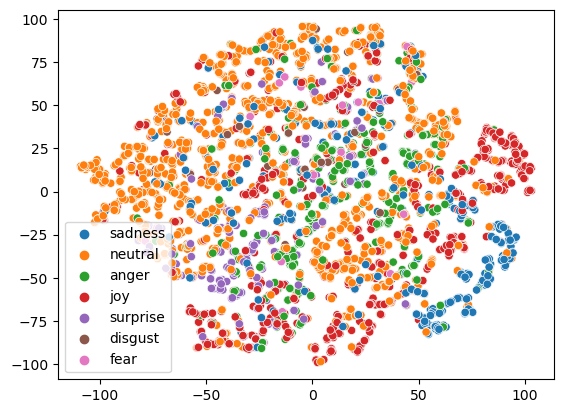

Epoch: 3 - Train Loss: 4.883072010140294


100%|█████████████████████████████████████████████| 4/4 [00:05<00:00,  1.34s/it]


Cosine Similarity between mods: 0.7170881352094017
General - KNN F1: 0.634271758635949 Acc: 0.6434692287717476
Iemocap - KNN F1: 0.6979641959091312 Acc: 0.6954069298952458
Iemocap - KNN F1 - Only Audio: 0.2503778449737185
Meld - KNN F1: 0.5934615611661183 Acc: 0.6187739463601533
Iemocap - KNN F1 (macro): 0.5533124252678485
Meld - KNN F1 (macro): 0.3796248994935229


Epoch: 4 - Train Loss: 4.805935186393252


100%|█████████████████████████████████████████████| 4/4 [00:05<00:00,  1.34s/it]


Cosine Similarity between mods: 0.7406464692865895
General - KNN F1: 0.6358095438389575 Acc: 0.6374967540898467
Iemocap - KNN F1: 0.717369924965855 Acc: 0.7155519742143432
Iemocap - KNN F1 - Only Audio: 0.2942429890271576
Meld - KNN F1: 0.5888420692368364 Acc: 0.6003831417624521
Iemocap - KNN F1 (macro): 0.5698599616098362
Meld - KNN F1 (macro): 0.40188315433357324


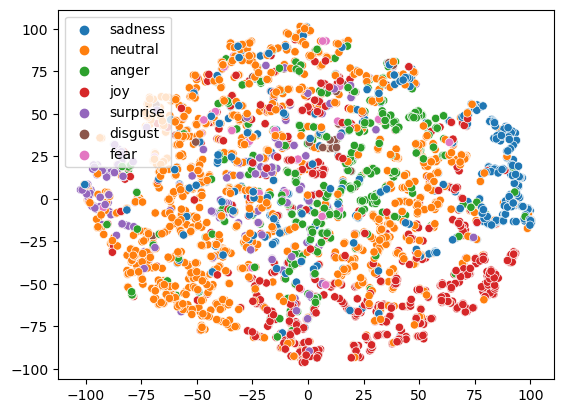

Epoch: 5 - Train Loss: 4.736984902999821


100%|█████████████████████████████████████████████| 4/4 [00:05<00:00,  1.36s/it]


Cosine Similarity between mods: 0.7669611801825013
General - KNN F1: 0.6434267119347875 Acc: 0.6507400675149312
Iemocap - KNN F1: 0.7375349415118192 Acc: 0.7332796132151491
Iemocap - KNN F1 - Only Audio: 0.3279509318516118
Meld - KNN F1: 0.5940025242398504 Acc: 0.6114942528735632
Iemocap - KNN F1 (macro): 0.5902604148717525
Meld - KNN F1 (macro): 0.3957556573302129


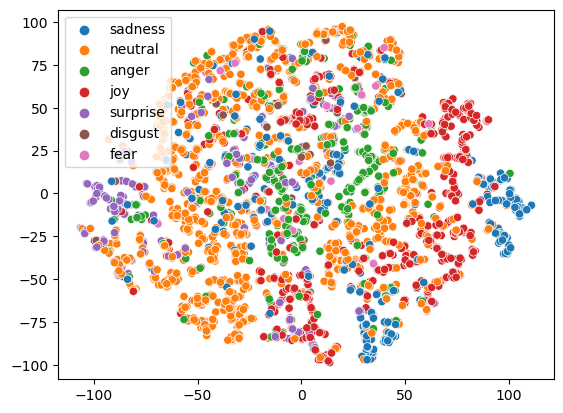

Epoch: 6 - Train Loss: 4.682336467928654


100%|█████████████████████████████████████████████| 4/4 [00:05<00:00,  1.35s/it]


Cosine Similarity between mods: 0.7251320806486952
General - KNN F1: 0.6439101677911192 Acc: 0.6535964684497533
Iemocap - KNN F1: 0.7528697223935168 Acc: 0.7493956486704271
Iemocap - KNN F1 - Only Audio: 0.25994090450295065
Meld - KNN F1: 0.5858175579634491 Acc: 0.6080459770114942
Iemocap - KNN F1 (macro): 0.49682712686851094
Meld - KNN F1 (macro): 0.40673750458582225


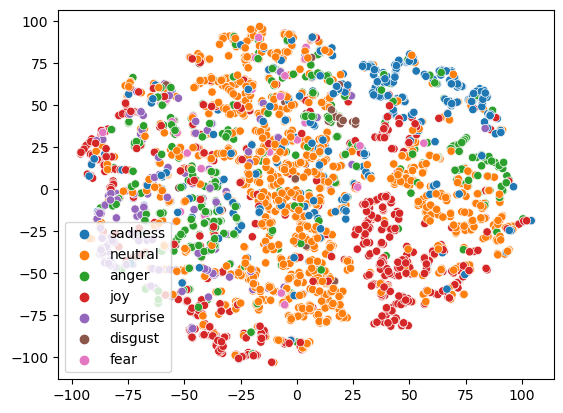

Epoch: 7 - Train Loss: 4.629134981819753


100%|█████████████████████████████████████████████| 4/4 [00:05<00:00,  1.34s/it]


Cosine Similarity between mods: 0.7409909827094423
General - KNN F1: 0.6275239129047642 Acc: 0.6310049337834329
Iemocap - KNN F1: 0.7405673669924517 Acc: 0.7373086220789685
Iemocap - KNN F1 - Only Audio: 0.3576634745554244
Meld - KNN F1: 0.5677178977992433 Acc: 0.5804597701149425
Iemocap - KNN F1 (macro): 0.5872135789613752
Meld - KNN F1 (macro): 0.37067672030330323


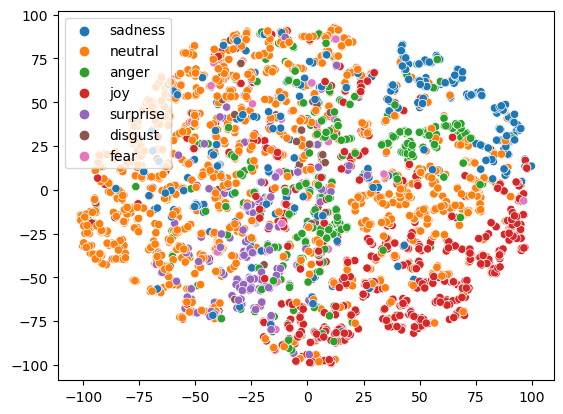

Epoch: 8 - Train Loss: 4.594483448771502


100%|█████████████████████████████████████████████| 4/4 [00:05<00:00,  1.33s/it]


Cosine Similarity between mods: 0.7736168650644719
General - KNN F1: 0.6281523090290718 Acc: 0.6382757725266165
Iemocap - KNN F1: 0.7112316725922091 Acc: 0.7050765511684126
Iemocap - KNN F1 - Only Audio: 0.3298949892507422
Meld - KNN F1: 0.5813285898738768 Acc: 0.6065134099616858
Iemocap - KNN F1 (macro): 0.4730820324595828
Meld - KNN F1 (macro): 0.38975559387776176


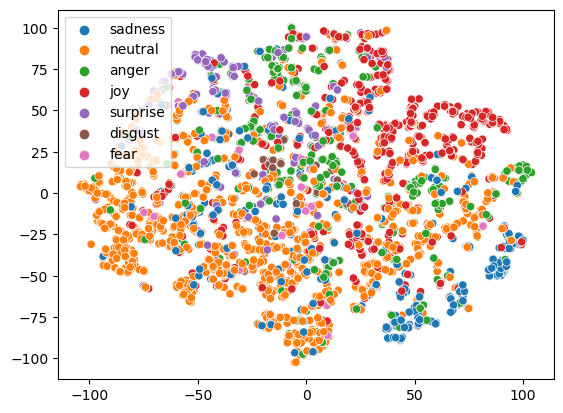

Epoch: 9 - Train Loss: 4.557488727212399


100%|█████████████████████████████████████████████| 4/4 [00:05<00:00,  1.34s/it]


Cosine Similarity between mods: 0.7639732628294599
General - KNN F1: 0.6244140619207909 Acc: 0.626850168787328
Iemocap - KNN F1: 0.7075335013543674 Acc: 0.7107171635777598
Iemocap - KNN F1 - Only Audio: 0.36797537943360487
Meld - KNN F1: 0.5822423792050446 Acc: 0.5869731800766284
Iemocap - KNN F1 (macro): 0.5616721813127006
Meld - KNN F1 (macro): 0.4040961998866824


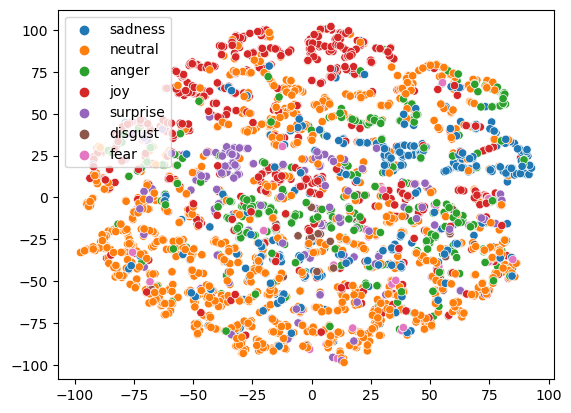

Epoch: 10 - Train Loss: 4.528570262680339


100%|█████████████████████████████████████████████| 4/4 [00:05<00:00,  1.31s/it]


Cosine Similarity between mods: 0.7574740251111725
General - KNN F1: 0.6364173588168152 Acc: 0.6421708647104648
Iemocap - KNN F1: 0.7275730024314796 Acc: 0.7244157937147462
Iemocap - KNN F1 - Only Audio: 0.370168937941532
Meld - KNN F1: 0.5917479795947934 Acc: 0.6030651340996168
Iemocap - KNN F1 (macro): 0.5841485552434478
Meld - KNN F1 (macro): 0.40718381371586215


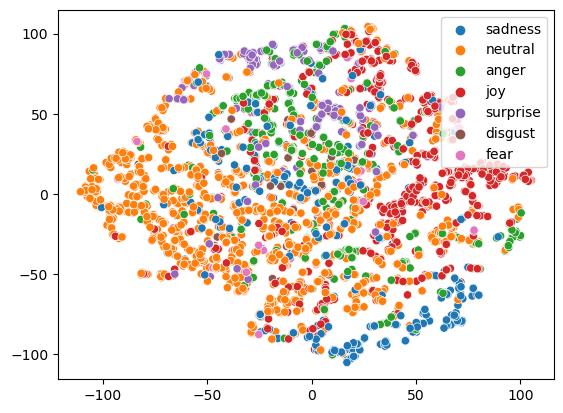

Epoch: 11 - Train Loss: 4.499711863557051


100%|█████████████████████████████████████████████| 4/4 [00:05<00:00,  1.32s/it]


Cosine Similarity between mods: 0.7542632208709994
General - KNN F1: 0.6330259728970951 Acc: 0.6419111918982082
Iemocap - KNN F1: 0.7163974010944368 Acc: 0.7115229653505237
Iemocap - KNN F1 - Only Audio: 0.3888989672878654
Meld - KNN F1: 0.5907329591447043 Acc: 0.6088122605363985
Iemocap - KNN F1 (macro): 0.5716744723179839
Meld - KNN F1 (macro): 0.40697674999146144


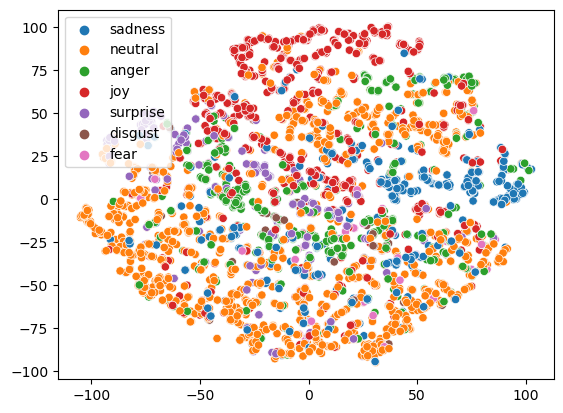

Epoch: 12 - Train Loss: 4.476738193954867


100%|█████████████████████████████████████████████| 4/4 [00:05<00:00,  1.32s/it]


Cosine Similarity between mods: 0.7689038130315178
General - KNN F1: 0.6316378563827776 Acc: 0.6445079200207738
Iemocap - KNN F1: 0.7384308099636299 Acc: 0.7348912167606769
Iemocap - KNN F1 - Only Audio: 0.43536808755238915
Meld - KNN F1: 0.5798625391708822 Acc: 0.6015325670498084
Iemocap - KNN F1 (macro): 0.5919997628121986
Meld - KNN F1 (macro): 0.3981377394066347


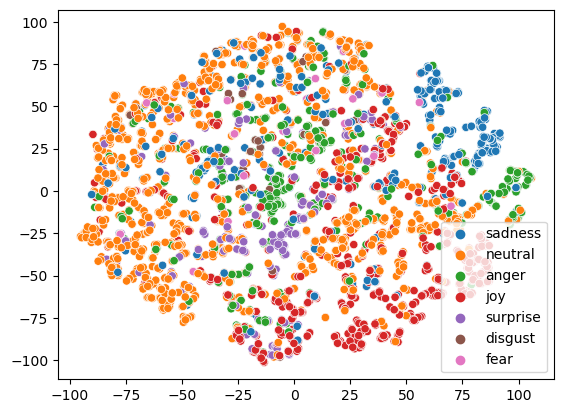

Epoch: 13 - Train Loss: 4.451688112837545


100%|█████████████████████████████████████████████| 4/4 [00:05<00:00,  1.36s/it]


Cosine Similarity between mods: 0.7436099630676285
General - KNN F1: 0.6020070917408776 Acc: 0.5988055050636198
Iemocap - KNN F1: 0.6990482454857789 Acc: 0.6946011281224819
Iemocap - KNN F1 - Only Audio: 0.3899420791663005
Meld - KNN F1: 0.5589133846779152 Acc: 0.5532567049808429
Iemocap - KNN F1 (macro): 0.5603182495116886
Meld - KNN F1 (macro): 0.39145122021775264


Epoch: 14 - Train Loss: 4.436568010165897


100%|█████████████████████████████████████████████| 4/4 [00:05<00:00,  1.35s/it]


Cosine Similarity between mods: 0.7602848438311478
General - KNN F1: 0.6138746050395943 Acc: 0.6177616203583485
Iemocap - KNN F1: 0.7155250513515178 Acc: 0.7074939564867043
Iemocap - KNN F1 - Only Audio: 0.39081565273319685
Meld - KNN F1: 0.5652671846635836 Acc: 0.575095785440613
Iemocap - KNN F1 (macro): 0.4762321850982276
Meld - KNN F1 (macro): 0.38099934013528103


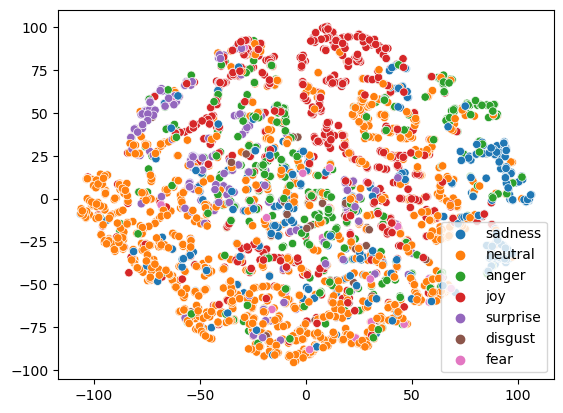

Epoch: 15 - Train Loss: 4.417066727684678


100%|█████████████████████████████████████████████| 4/4 [00:05<00:00,  1.33s/it]


Cosine Similarity between mods: 0.7782051841242534
General - KNN F1: 0.6290063490779887 Acc: 0.6351596987795378
Iemocap - KNN F1: 0.7400238797645978 Acc: 0.7356970185334408
Iemocap - KNN F1 - Only Audio: 0.39071581255616983
Meld - KNN F1: 0.5739960892295621 Acc: 0.5873563218390805
Iemocap - KNN F1 (macro): 0.5943109407040998
Meld - KNN F1 (macro): 0.3892956603308399


Epoch: 16 - Train Loss: 4.401711467500037


 11%|████▋                                     | 30/267 [00:23<03:01,  1.31it/s]

In [ ]:
train_ds = torch.utils.data.TensorDataset(torch.Tensor(list(range(len(df_train)))))
train_loader = torch.utils.data.DataLoader(train_ds, batch_size=256, shuffle=True)

test_ds = torch.utils.data.TensorDataset(torch.Tensor(list(range(len(test_df_erc)))))
test_loader = torch.utils.data.DataLoader(test_ds, batch_size=1024, shuffle=False)

PATH_TO_SAVE = 'ESTAMOS_PERTO_AMIGO_ESTOU_AQUI_4_freezed_11'
!mkdir -p {PATH_TO_SAVE}
supcon_model = AudioTextContrastive(
    text_encoder,
    audio_encoder,
    in_features_text=384,
    in_features_audio=dim_embed, 
    hidden_size=1024,
    wide_proj=2048,
    proj_size=128, 
    freeze_text_enc=False,
    freeze_audio_enc=False,
    rate=0.2,
)

# Grid search best temperatures
# Try to only fine tune on evaluation datasets
#supcon_model.load_state_dict(torch.load(f'ESTAMOS_PERTO_AMIGO_ESTOU_AQUI_4_freezed_4_layer/pytorch_model_AudioTextCLIP_epoch_9.bin')['model'])

supcon_model.to(0)

scaler = torch.cuda.amp.GradScaler()

step = 0
e = 0
patience = 9999
early_stop_flag = 0
old_f1 = -float('inf')

param_optimizer = list(supcon_model.named_parameters())
no_decay = ['bias', 'gamma', 'beta']
optimizer_grouped_parameters = [{
    'params':
    [p for n, p in param_optimizer if not any(nd in n for nd in no_decay)],
    'weight_decay_rate':
    0.1
}, {
    'params':
    [p for n, p in param_optimizer if any(nd in n for nd in no_decay)],
    'weight_decay_rate':
    0.0
}]

scheduler_epochs = 5
opt = torch.optim.AdamW(optimizer_grouped_parameters, lr=0, betas=(0.9, 0.98), eps=1e-8)
#scheduler = torch.optim.lr_scheduler.LinearLR(opt, start_factor=0.5, end_factor=0.9, total_iters=10, last_epoch=- 1, verbose=False)
scheduler = Scheduler(opt, 768, 600)

epochs = 9999

while e < epochs:
    supcon_model.train()
    epoch_loss = 0.0
    proj_val = []
    targets_val = []

    proj_train = []
    targets_train = []

    for i, batch_indices in enumerate(tqdm(train_loader, total=len(train_loader))):
        if i == len(train_loader)-1:
            continue
        batch = df_train.iloc[batch_indices[0]]
        only_text = batch[batch["path"].isna()]
        sentences = only_text["text"].tolist()
        y_text = torch.Tensor(lab_encoder.transform(only_text["label"]))
        y_text_senti = torch.Tensor(lab_encoder_senti.transform(only_text["sentiment_label"]))
        
        only_audio = batch[batch["text"].isna()]
        audio_paths = only_audio["path"].tolist()
        try:
            mfccs, att = audio_tokenizer.batch_tokenize(audio_paths)

            audio_input = {
                "features": mfccs.to(0),
                "attn_masks": att.to(0),
            }
        except:
            audio_input = None

        y_audio = torch.Tensor(lab_encoder.transform(only_audio["label"]))
        y_audio_senti = torch.Tensor(lab_encoder_senti.transform(only_audio["sentiment_label"]))
        
        mult = batch[batch["text"].notna()]
        mult = mult[mult["path"].notna()].reset_index(drop=True)
        
        mult_not_na_idx = mult[mult["label"].notna()].index
        #batch_not_na_idx = batch[batch["label"].notna()].index
        #mult_na_idx = mult[mult["label"].isna()].index
        
        y_mult = torch.Tensor(lab_encoder.transform(mult.iloc[mult_not_na_idx]["label"]))
        
        y_mult_senti = torch.Tensor(lab_encoder_senti.transform(mult["sentiment_label"]))
        
        audio_path_mult = [str(t['path']) for _, t in mult.iterrows()]
        
        mfccs_mult, att_mult = audio_tokenizer.batch_tokenize(audio_path_mult)
        
        sentences_mult = [str(t['text']) for _, t in mult.iterrows()]
        
        multimodal = {'sentences': sentences_mult, 
                      'audio_input': {"features": mfccs_mult.to(0), "attn_masks": att_mult.to(0)}}
        
        target = torch.cat([y_text, y_audio, y_mult]).long().cuda()
        target_senti = torch.cat([y_text_senti, y_audio_senti, y_mult_senti]).long().cuda()
        
        x = [sentences, audio_input, multimodal]
        
        if len(sentences) == 0:
            x[0] = None
        if len(audio_paths) == 0:
            x[1] = None
        if len(sentences_mult) == 0:
            x[2] = None

        with torch.cuda.amp.autocast(enabled=True, dtype=torch.float16) as autocast, torch.backends.cuda.sdp_kernel(enable_flash=False) as disable:
            
            out = supcon_model(x)
            
            # Multimodal loss
            if x[-1] is not None:
                x_mult_text = out["x_mult_text"]
                x_mult_audio = out["x_mult_audio"]
                x_mult_text_norm = F.normalize(x_mult_text, dim=-1)
                x_mult_audio_norm = F.normalize(x_mult_audio, dim=-1)
                
                #weights = torch.stack([torch.norm(x_mult_audio, dim=-1), torch.norm(x_mult_text, dim=-1)], dim=0).detach()
                weights = torch.cat([torch.norm(x_mult_audio, dim=-1), torch.norm(x_mult_text, dim=-1)], dim=0).detach()
                #weights = torch.ones_like(weights)
                
                # Augument modality
                augs = random.choices(
                    population=[0, 1, 2],
                    weights=[0.5, 0.25, 0.25],
                    k=len(x_mult_text)
                )
                
                x_mult = torch.stack([F.normalize(x_mult_text + x_mult_audio, dim=-1), 
                                      x_mult_text_norm, 
                                     x_mult_audio_norm], dim=1)

                x_mult = x_mult[list(range(len(augs))), augs, :] 
                x_mult_wide = F.normalize(out["x_mult_text_wide"] + out["x_mult_audio_wide"], dim=-1)
                
                # Add weighted contrastive loss
                #x_mult_text = x_mult_text_norm.unsqueeze(dim=1)
                #x_mult_audio = x_mult_audio_norm.unsqueeze(dim=1)
                #mult = torch.cat([x_mult_text, x_mult_audio], dim=1)
                
                out_x, out_x_wide = None, None
                
                if x[0] is not None:
                    if x[1] is not None:
                        out_x = torch.cat([out["x_text"], out["x_audio"], x_mult], dim=0) #.unsqueeze(dim=1)
                        out_x_lab = torch.cat([out["x_text"], out["x_audio"], x_mult[mult_not_na_idx]], dim=0) #.unsqueeze(dim=1)
                        out_x_wide = torch.cat([out["x_text_wide"], out["x_audio_wide"], x_mult_wide[mult_not_na_idx]], dim=0)
                    else:
                        out_x = torch.cat([out["x_text"], x_mult], dim=0) #.unsqueeze(dim=1)
                        out_x_lab = torch.cat([out["x_text"], x_mult[mult_not_na_idx]], dim=0) #.unsqueeze(dim=1)
                        out_x_wide = torch.cat([out["x_text_wide"], x_mult_wide[mult_not_na_idx]], dim=0)
                elif x[1] is not None:
                    out_x = torch.cat([out["x_audio"], x_mult], dim=0) #.unsqueeze(dim=1)
                    out_x_lab = torch.cat([out["x_audio"], x_mult[mult_not_na_idx]], dim=0) #.unsqueeze(dim=1)
                    out_x_wide = torch.cat([out["x_audio_wide"], x_mult_wide[mult_not_na_idx]], dim=0)
                else:
                    out_x = x_mult.unsqueeze(dim=1)
                    out_x_lab = x_mult[mult_not_na_idx] #.unsqueeze(dim=1)
                    out_x_wide = x_mult_wide[mult_not_na_idx]
                
                # fera ta
                
                loss = 0.8 * (0.8 * sup_contrastive_loss(out_x_lab, target, temperature=0.1) + 0.2 * sup_contrastive_loss(out_x, target_senti, temperature=0.1)) + 0.2 * unsupervised_contrastive_loss(x_mult_text_norm, x_mult_audio_norm, temperature=0.1, weights=None)
                #loss = 0.5 * (0.5 * supcon_loss(out_x_lab, labels=target) + 0.5 * supcon_loss_senti(out_x, labels=target_senti)) + 0.5 * supcon_loss_intra(mult, weights=weights) 
            else:
                if x[0] is not None:
                    if x[1] is not None:
                        out_x = torch.cat([out["x_text"], out["x_audio"]], dim=0).unsqueeze(dim=1)
                        out_x_wide = torch.cat([out["x_text_wide"], out["x_audio_wide"]], dim=0)
                    else:
                        out_x = out["x_text"]
                        out_x_wide = out["x_text_wide"]
                else:
                    if x[1] is not None:
                        out_x = out["x_audio"]
                        out_x_wide = out["x_audio_wide"]
                    else:
                        raise Exception("Nothing to work :()")
                        
                loss = 0.5 * sup_contrastive_loss(out_x_lab, target, temperature=0.2) + 0.5 * sup_contrastive_loss(out_x, target_senti, temperature=0.1) #+ 0.8 * unsupervised_contrastive_loss(x_mult_text_norm, x_mult_audio_norm, temperature=0.8, weights=None)

        scaler.scale(loss).backward()
        scaler.unscale_(opt)

        torch.nn.utils.clip_grad_norm_(supcon_model.parameters(), 30.0)
        scaler.step(opt)
        scheduler.step()
        scaler.update()
        
        opt.zero_grad(set_to_none=True)

        epoch_loss += loss.item()
        proj_train.append(np.array(out_x_wide.detach().cpu()))
        targets_train.append(np.array(target.cpu()))

        del out_x
        del x_mult
        del out_x_wide
        gc.collect()
        torch.cuda.empty_cache()
    #scheduler.step()
    proj_train = np.concatenate(proj_train, axis=0)
    targets_train = np.concatenate(targets_train, axis=0)
    
    clf = FaissKNeighbors(k=128)
    clf.fit(proj_train, np.array(targets_train, dtype=int))

    epoch_loss = epoch_loss/len(train_loader)
    supcon_model.eval()
    preds = []
    targets = []
    css = 0.0
    wide_audio = []
    
    for i, batch_indices in enumerate(tqdm(test_loader, total=len(test_loader))):
        with torch.no_grad():
        
            multimodal_batch = test_df_erc.iloc[batch_indices[0]]

            audio_path_mult = [str(t['path']) for _, t in multimodal_batch.iterrows()]
            mfccs_mult, att_mult = audio_tokenizer.batch_tokenize(audio_path_mult)

            sentences_mult = [str(t['text']) for _, t in multimodal_batch.iterrows()]

            multimodal = {'sentences': sentences_mult, 
                          'audio_input': {"features": mfccs_mult.to(0), "attn_masks": att_mult.to(0)}}
        
            target = torch.Tensor(lab_encoder.transform(list(multimodal_batch["label"])))

            x = [None, None, multimodal]
            with torch.cuda.amp.autocast(enabled=True, dtype=torch.float16) as autocast, torch.backends.cuda.sdp_kernel(enable_flash=False) as disable:
                out = supcon_model(x)
            
            # Multimodal loss
            out_x_wide = F.normalize(out["x_mult_text_wide"] + out["x_mult_audio_wide"], dim=-1)
            
            cs = F.cosine_similarity(F.normalize(out["x_mult_text_wide"], dim=-1), F.normalize(out["x_mult_audio_wide"], dim=-1))

            wide = np.array(out_x_wide.cpu())
            wide_audio.append(np.array(F.normalize(out["x_mult_audio_wide"], dim=-1).cpu()))
            pred = clf.predict(wide)
            preds.append(pred)

            assert len(wide) == len(pred)

            proj_val.append(wide)
            targets_val.append(np.array(target.cpu()))
            css += np.sum(np.array(cs.cpu()))
            del out_x_wide
            gc.collect()
            torch.cuda.empty_cache()

    proj_val = np.concatenate(proj_val, axis=0)
    wide_audio = np.concatenate(wide_audio, axis=0)
    targets_val = np.concatenate(targets_val, axis=0)
    
    preds = np.array(np.concatenate(preds, axis=0))
    
    css = css / len(test_df_erc)

    general_f1 = f1_score(targets_val, preds, average='weighted')
    general_acc = accuracy_score(targets_val, preds)
    
    print(f'Cosine Similarity between mods: {css}')
    
    meld_idx = test_df_erc[test_df_erc["source"] == "meld"].index
    iemocap_idx = test_df_erc[test_df_erc["source"] != "meld"].index
    
    general_f1_iemocap = f1_score(targets_val[iemocap_idx], preds[iemocap_idx], average='weighted')
    general_f1_iemocap_audio = f1_score(targets_val[iemocap_idx], clf.predict(wide_audio)[iemocap_idx], average='weighted')
    general_acc_iemocap = accuracy_score(targets_val[iemocap_idx], preds[iemocap_idx])
    
    general_f1_meld = f1_score(targets_val[meld_idx], preds[meld_idx], average='weighted')
    general_acc_meld = accuracy_score(targets_val[meld_idx], preds[meld_idx])
    
    print(f'General - KNN F1: {general_f1} Acc: {general_acc}')
    print(f'Iemocap - KNN F1: {general_f1_iemocap} Acc: {general_acc_iemocap}')
    print(f'Iemocap - KNN F1 - Only Audio: {general_f1_iemocap_audio}')
    print(f'Meld - KNN F1: {general_f1_meld} Acc: {general_acc_meld}')
    
    print(f"Iemocap - KNN F1 (macro): {f1_score(targets_val[iemocap_idx], preds[iemocap_idx], average='macro')}")
    print(f"Meld - KNN F1 (macro): {f1_score(targets_val[meld_idx], preds[meld_idx], average='macro')}")

    try:
        tsne = TSNE(n_components=2, learning_rate='auto', init='pca', perplexity=5).fit_transform(proj_val)

        sns.scatterplot(x=tsne[:, 0], y=tsne[:, 1], hue=lab_encoder.inverse_transform(list(np.array(targets_val, dtype=int))) , palette='tab10')
        plt.show()
    
    except:
        pass
    
    print(f'Epoch: {e + 1} - Train Loss: {epoch_loss}')
    e += 1
    
    #if e == scheduler_epochs: # Unfreeze text encoder
    #    for i, (name, param) in enumerate(list(supcon_model.text_encoder.named_parameters())):
    #        param.requires_grad = True

    with open(f"{PATH_TO_SAVE}/metrics_epoch_{e}.txt", "w") as f:
        f.write(f'General - KNN F1: {general_f1} Acc: {general_acc}')
        f.write(f'Iemocap - KNN F1: {general_f1_iemocap} Acc: {general_acc_iemocap}')
        f.write(f'Meld - KNN F1: {general_f1_meld} Acc: {general_acc_meld}')
        f.write(f"Iemocap - KNN F1 (macro): {f1_score(targets_val[iemocap_idx], preds[iemocap_idx], average='macro')}")
        f.write(f"Meld - KNN F1 (macro): {f1_score(targets_val[meld_idx], preds[meld_idx], average='macro')}")
        
    checkpoint = {"model": supcon_model.state_dict(),
              "optimizer": opt.state_dict(),
              "scaler": scaler.state_dict()}
    torch.save(checkpoint, f'{PATH_TO_SAVE}/pytorch_model_AudioTextCLIP_epoch_{e}.bin')

In [ ]:
"""
Cosine Similarity between mods: 0.6148036817116292
General - KNN F1: 0.652949920693673 Acc: 0.6535964684497533
Iemocap - KNN F1: 0.7621117618450867 Acc: 0.7558420628525383
Iemocap - KNN F1 - Only Audio: 0.48286032752145575
Meld - KNN F1: 0.6025222678926638 Acc: 0.6049808429118774
Iemocap - KNN F1 (macro): 0.6085758686292261
Meld - KNN F1 (macro): 0.41899567212117655

Epoch: 31 - Train Loss: 6.175596459077136
"""

## Eval

In [ ]:
#import pickle
#pickle.dump(kmeans, open("./transformer_1_layer_repetindo/kmeans_200_clusters_curr.pkl", 'wb'))

In [ ]:
gc.collect()

In [ ]:
#PATH_TO_SAVE = 'ESTAMOS_PERTO_AMIGO_ESTOU_AQUI_4_freezed_5_layer_pivoting_to_speech_training'

In [ ]:
#torch.load(f'pre_test_final_2/pytorch_model_AudioTextCLIP_epoch_35.bin')['model']
#torch.load(f'{PATH_TO_SAVE}/pytorch_model_AudioTextCLIP_epoch_1.bin')['model']

In [ ]:
PATH_TO_SAVE = 'ESTAMOS_PERTO_AMIGO_ESTOU_AQUI_4_freezed_11'

supcon_model = AudioTextContrastive(
    text_encoder,
    audio_encoder,
    in_features_text=768,
    in_features_audio=dim_embed, 
    hidden_size=1024,
    wide_proj=2048,
    proj_size=128, 
    freeze_text_enc=True,
    freeze_audio_enc=True,
    rate=0.2,
).cuda()
supcon_model.load_state_dict(torch.load(f'{PATH_TO_SAVE}/pytorch_model_AudioTextCLIP_epoch_17.bin')['model'])

In [ ]:
def get_n_params(model):
    pp=0
    for p in list(model.parameters()):
        nn=1
        for s in list(p.size()):
            nn = nn*s
        pp += nn
    return pp

In [ ]:
get_n_params(supcon_model)

In [ ]:
supcon_model.eval()

In [ ]:
import pickle

In [ ]:
test = supcon_model([["I Hate you, i believe you are shit!", "You are my best friend, love you!"],None, None])
torch.dot(F.normalize(test["x_text_wide"][0, :], dim=-1), F.normalize(test["x_text_wide"][1, :], dim=-1))

In [ ]:
test = supcon_model([["The best man ever, keep the good work!", "you are my best friend, love you!"],None, None])
torch.dot(F.normalize(test["x_text_wide"][0, :], dim=-1), F.normalize(test["x_text_wide"][1, :], dim=-1))

In [ ]:
test = supcon_model([["I Hate you, i believe you are shit!", "Fuck you, you should not be alive"],None, None])
torch.dot(F.normalize(test["x_text_wide"][0, :], dim=-1), F.normalize(test["x_text_wide"][1, :], dim=-1))

In [ ]:
with torch.no_grad():
    m, a = audio_tokenizer.batch_tokenize(["./audio/audio_emo/tess.woman.sad.100.wav"])
    audio_input = {
        "features": m.to(0),
        "attn_masks": a.to(0),
    }
    test = supcon_model([["I am sad"],audio_input, None])
    print(torch.dot(F.normalize(test["x_text_wide"][0, :], dim=-1), F.normalize(test["x_audio_wide"][0, :], dim=-1)))

In [ ]:
with torch.no_grad():
    m, a = audio_tokenizer.batch_tokenize(["./audio/audio_emo/tess.woman.sad.101.wav"])
    audio_input = {
        "features": m.to(0),
        "attn_masks": a.to(0),
    }
    test = supcon_model([["I am Happy"],audio_input, None])
    print(torch.dot(F.normalize(test["x_text_wide"][0, :], dim=-1), F.normalize(test["x_audio_wide"][0, :], dim=-1)))

In [ ]:
with torch.no_grad():
    m, a = audio_tokenizer.batch_tokenize(["./audio/audio_emo/tess.woman.sad.279.wav"])
    audio_input = {
        "features": m.to(0),
        "attn_masks": a.to(0),
    }
    test = supcon_model([["I am sad"], audio_input, None])
    print(torch.dot(F.normalize(test["x_text_wide"][0, :], dim=-1), F.normalize(test["x_audio_wide"][0, :], dim=-1)))

In [ ]:
with torch.no_grad():
    m, a = audio_tokenizer.batch_tokenize(["./audio/audio_emo/tess.woman.sad.279.wav"])
    audio_input = {
        "features": m.to(0),
        "attn_masks": a.to(0),
    }
    test = supcon_model([["I am happy"], audio_input, None])
    print(torch.dot(F.normalize(test["x_text_wide"][0, :], dim=-1), F.normalize(test["x_audio_wide"][0, :], dim=-1)))

In [ ]:
with torch.no_grad():
    m, a = audio_tokenizer.batch_tokenize(["./audio/audio_emo/tess.woman.happy.50.wav"])
    audio_input = {
        "features": m.to(0),
        "attn_masks": a.to(0),
    }
    test = supcon_model([["I am sad"],audio_input, None])
    print(torch.dot(F.normalize(test["x_text_wide"][0, :], dim=-1), F.normalize(test["x_audio_wide"][0, :], dim=-1)))

In [ ]:
with torch.no_grad():
    m, a = audio_tokenizer.batch_tokenize(["./audio/audio_emo/tess.woman.happy.50.wav"])
    audio_input = {
        "features": m.to(0),
        "attn_masks": a.to(0),
    }
    test = supcon_model([["I am happy"],audio_input, None])
    print(torch.dot(F.normalize(test["x_text_wide"][0, :], dim=-1), F.normalize(test["x_audio_wide"][0, :], dim=-1)))

In [ ]:
with torch.no_grad():
    m, a = audio_tokenizer.batch_tokenize(["./audio/audio_emo/tess.woman.happy.50.wav", "./audio/audio_emo/crema.man.happy157.wav"])
    audio_input = {
        "features": m.to(0),
        "attn_masks": a.to(0),
    }
    test = supcon_model([["you are my best friend, love you!"],audio_input, None])
    print(torch.dot(F.normalize(test["x_audio_wide"][0, :], dim=-1), F.normalize(test["x_audio_wide"][1, :], dim=-1)))

In [ ]:
#supcon_model.load_state_dict(torch.load('./pytorch_model_AudioTextCLIPvFinal_epoch_25_only_meld.bin'))

In [ ]:
#supcon_model.audio_encoder.clusterization_model = kmeans

In [ ]:
gc.collect()

In [ ]:
df_train_f =df_train

In [ ]:
#df_dev_audio = pd.concat([df_meld_dev, test_audio], axis=0)

# Param: Select dataset for scoring

In [ ]:
meld_train_idx = train_df_erc[train_df_erc["path"].apply(lambda x: True if "MELD" in x else False)].index

In [ ]:
iemocap_train_idx = train_df_erc[train_df_erc["path"].apply(lambda x: False if "MELD" in x else True)].index

In [ ]:
#train_audio_repeated = pd.concat([df_train_audio, df_train_audio,df_train_audio,df_train_audio,df_train_audio,df_train_audio,df_train_audio, df_train_audio,df_train_audio,df_train_audio,df_train_audio,df_train_audio], axis=0).sample(frac=1).reset_index(drop=True)
#test_audio_repeated = pd.concat([df_dev_audio, df_dev_audio,df_dev_audio,df_dev_audio,df_dev_audio,df_dev_audio], axis=0).sample(frac=1).reset_index(drop=True)
train_iemocap = train_df_erc.iloc[iemocap_train_idx].reset_index(drop=True)
#train_iemocap = train_df_erc.iloc[meld_train_idx].reset_index(drop=True)
train_ds = torch.utils.data.TensorDataset(torch.Tensor(list(range(len(train_iemocap)))))
train_loader = torch.utils.data.DataLoader(train_ds, batch_size=1024, shuffle=False)

test_ds = torch.utils.data.TensorDataset(torch.Tensor(list(range(len(test_df_erc)))))
test_loader = torch.utils.data.DataLoader(test_ds, batch_size=1024, shuffle=False)

In [ ]:
gc.collect()

In [ ]:
supcon_model.eval()

proj_val = []
targets_val = []

proj_train = []
targets_train = []

for i, batch_indices in enumerate(tqdm(train_loader, total=len(train_loader))):
    with torch.no_grad():
        batch = train_iemocap.iloc[batch_indices[0]]
        only_text = batch[batch["path"].isna()]
        sentences = only_text["text"].tolist()
        y_text = torch.Tensor(lab_encoder.transform(only_text["label"]))

        only_audio = batch[batch["text"].isna()]
        audio_paths = only_audio["path"].tolist()
        try:
            mfccs, att = audio_tokenizer.batch_tokenize(audio_paths)

            audio_input = {
                "features": mfccs.to(0),
                "attn_masks": att.to(0),
            }
        except:
            audio_input = None

        y_audio = torch.Tensor(lab_encoder.transform(only_audio["label"]))

        mult = batch[batch["text"].notna()]
        mult = mult[mult["path"].notna()]
        mult = mult[mult["label"].notna()]
        y_mult = torch.Tensor(lab_encoder.transform(mult["label"]))

        audio_path_mult = [str(t['path']) for _, t in mult.iterrows()]

        mfccs_mult, att_mult = audio_tokenizer.batch_tokenize(audio_path_mult)

        sentences_mult = [str(t['text']) for _, t in mult.iterrows()]

        multimodal = {'sentences': sentences_mult, 
                      'audio_input': {"features": mfccs_mult.to(0), "attn_masks": att_mult.to(0)}}

        target = torch.cat([y_text, y_audio, y_mult])

        x = [sentences, audio_input, multimodal]

        if len(sentences) == 0:
            x[0] = None
        if len(audio_paths) == 0:
            x[1] = None
        if len(sentences_mult) == 0:
            x[2] = None

        with torch.cuda.amp.autocast(enabled=True, dtype=torch.float16) as autocast, torch.backends.cuda.sdp_kernel(enable_flash=False) as disable:

            out = supcon_model(x)

            # Multimodal loss
            x_mult_wide = F.normalize(out["x_mult_text_wide"] + out["x_mult_audio_wide"], dim=-1)
            #x_mult_wide = F.normalize(out["x_mult_audio_wide"], dim=-1)

        proj_train.append(np.array(x_mult_wide.detach().cpu()))
        targets_train.append(np.array(target.cpu()))

        del x_mult_wide
        gc.collect()
        torch.cuda.empty_cache()
proj_train = np.concatenate(proj_train, axis=0)
targets_train = np.concatenate(targets_train, axis=0)

clf = FaissKNeighbors(k=128)
clf.fit(proj_train, np.array(targets_train, dtype=int))

supcon_model.eval()
preds = []
targets = []
css = 0.0

for i, batch_indices in enumerate(tqdm(test_loader, total=len(test_loader))):
    with torch.no_grad():

        multimodal_batch = test_df_erc.iloc[batch_indices[0]]

        audio_path_mult = [str(t['path']) for _, t in multimodal_batch.iterrows()]
        mfccs_mult, att_mult = audio_tokenizer.batch_tokenize(audio_path_mult)

        sentences_mult = [str(t['text']) for _, t in multimodal_batch.iterrows()]

        multimodal = {'sentences': sentences_mult, 
                      'audio_input': {"features": mfccs_mult.to(0), "attn_masks": att_mult.to(0)}}

        target = torch.Tensor(lab_encoder.transform(list(multimodal_batch["label"])))

        x = [None, None, multimodal]
        with torch.cuda.amp.autocast(enabled=True, dtype=torch.float16) as autocast, torch.backends.cuda.sdp_kernel(enable_flash=False) as disable:
            out = supcon_model(x)

            # Multimodal loss
            out_x_wide = F.normalize(out["x_mult_text_wide"] + out["x_mult_audio_wide"], dim=-1)
            #out_x_wide = F.normalize(out["x_mult_audio_wide"], dim=-1)

        cs = F.cosine_similarity(out["x_mult_text_wide"], out["x_mult_audio_wide"])

        wide = np.array(out_x_wide.cpu())
        pred = clf.predict(wide)
        preds.append(pred)

        assert len(wide) == len(pred)

        proj_val.append(wide)
        targets_val.append(np.array(target.cpu()))
        css += np.sum(np.array(cs.cpu()))
        del out_x_wide
        gc.collect()
        torch.cuda.empty_cache()

proj_val = np.concatenate(proj_val, axis=0)
targets_val = np.concatenate(targets_val, axis=0)

preds = np.array(np.concatenate(preds, axis=0))

css = css / len(test_df_erc)

general_f1 = f1_score(targets_val, preds, average='weighted')
general_acc = accuracy_score(targets_val, preds)

print(f'Cosine Similarity between mods: {css}')

meld_idx = test_df_erc[test_df_erc["source"] == "meld"].index
iemocap_idx = test_df_erc[test_df_erc["source"] != "meld"].index

general_f1_iemocap = f1_score(targets_val[iemocap_idx], preds[iemocap_idx], average='weighted')
general_acc_iemocap = accuracy_score(targets_val[iemocap_idx], preds[iemocap_idx])

general_f1_meld = f1_score(targets_val[meld_idx], preds[meld_idx], average='weighted')
general_acc_meld = accuracy_score(targets_val[meld_idx], preds[meld_idx])

print(f'General - KNN F1: {general_f1} Acc: {general_acc}')
print(f'Iemocap - KNN F1: {general_f1_iemocap} Acc: {general_acc_iemocap}')
print(f'Meld - KNN F1: {general_f1_meld} Acc: {general_acc_meld}')

print(f"Iemocap - KNN F1 (macro): {f1_score(targets_val[iemocap_idx], preds[iemocap_idx], average='macro')}")
print(f"Meld - KNN F1 (macro): {f1_score(targets_val[meld_idx], preds[meld_idx], average='macro')}")

tsne = TSNE(n_components=2, learning_rate='auto', init='pca', perplexity=5).fit_transform(proj_val)

sns.scatterplot(x=tsne[:, 0], y=tsne[:, 1], hue=lab_encoder.inverse_transform(list(np.array(targets_val, dtype=int))) , palette='tab10')
plt.show()

In [ ]:
train_iemocap

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPClassifier
mean_test = proj_train[meld_train_idx].mean(axis=0)
std_test = proj_train[meld_train_idx].std(axis=0)
clf = FaissKNeighbors(k=128)
clf.fit((proj_train[meld_train_idx]-mean_test)/std_test, np.array(targets_train[meld_train_idx], dtype=int))

preds = clf.predict((proj_val-mean_test)/std_test)

general_f1_meld = f1_score(targets_val[meld_idx], preds[meld_idx], average='weighted')
general_acc_meld = accuracy_score(targets_val[meld_idx], preds[meld_idx])

from sklearn.metrics import classification_report

print(classification_report(targets_val[meld_idx], preds[meld_idx], digits=4))

In [ ]:
len(targets_val[iemocap_idx])

In [ ]:
set(lab_encoder.inverse_transform(np.array(targets_val[iemocap_idx], dtype=int)))


In [ ]:
df_iemocap_orig = pd.read_json("emotions.json").reset_index(drop=False)
df_iemocap_orig = pd.melt(df_iemocap_orig, id_vars=['index'], value_vars=['train', 'val', 'test']).dropna().drop(columns=["variable"]).rename(columns={"index":"id", "value": "orig_label"}).reset_index(drop=True)
df_iemocap_orig = df_iemocap_orig[df_iemocap_orig["orig_label"].notna() & (df_iemocap_orig["orig_label"] != "undecided")].reset_index(drop=True)
df_iemocap_orig

In [ ]:
def cleaning_shit(x):
    if "MELD" in x:
        return None
    x = x.replace("val/", "")
    x = x.replace("train/", "")
    x = x.replace("test/", "")
    l = len("/home/vmachado/Documents/multimodal-datasets/IEMOCAP/raw-audios/")
    return x[l:].replace(".wav", "")


In [ ]:
#train_df_erc_iemocap = train_df_erc[train_df_erc["path"].apply(lambda x: True if "IEMOCAP" in x else False)]
train_df_erc["id"] = train_df_erc["path"].apply(cleaning_shit)
train_df_erc_iemocap = train_df_erc.dropna()
train_df_erc_iemocap = train_df_erc_iemocap.merge(df_iemocap_orig, on="id", how="inner").dropna()
train_df_erc_iemocap

In [ ]:
len(iemocap_train_idx)

In [ ]:
test_df_erc["id"] = test_df_erc["path"].apply(lambda x: x[len('/home/vmachado/Documents/multimodal-datasets/IEMOCAP/raw-audios/test/'):].replace(".wav", "")) 

In [ ]:
test_df_erc_iemocap = test_df_erc[test_df_erc["source"] == "iemocap"].reset_index(drop=True)
test_df_erc_iemocap

In [ ]:
test_df_erc_iemocap = test_df_erc_iemocap.merge(df_iemocap_orig, on="id", how="inner")
test_df_erc_iemocap

In [ ]:
new_lab = LabelEncoder().fit(train_df_erc_iemocap["orig_label"])

In [ ]:
train_df_erc_iemocap["orig_label"].unique()

In [ ]:
test_df_erc_iemocap["orig_label"].unique()

In [ ]:
train_df_erc_iemocap

In [ ]:
test_df_erc_iemocap

In [ ]:
correct_labels_train = new_lab.transform(train_df_erc_iemocap["orig_label"])
correct_labels_test = new_lab.transform(test_df_erc_iemocap["orig_label"])

In [ ]:
correct_labels_train

In [ ]:
lab_encoder.classes_

In [ ]:
test_df_erc[test_df_erc["source"] == "iemocap"]["label"].value_counts()

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPClassifier
mean_test = proj_train.mean(axis=0)
std_test = proj_train.std(axis=0)

#clf = MLPClassifier(hidden_layer_sizes=(768,), learning_rate="invscaling", solver="sgd", max_iter=5000, validation_fraction=0.2, nesterovs_momentum=False)
clf = LogisticRegression()
clf.fit((proj_train-mean_test)/std_test, np.array(targets_train, dtype=int))

preds = clf.predict((proj_val-mean_test)/std_test)

from sklearn.metrics import classification_report

print(classification_report(targets_val[iemocap_idx], preds[iemocap_idx], digits=4))

In [ ]:
general_f1_iemocap = f1_score(targets_val[iemocap_idx], preds[iemocap_idx], average='weighted')
general_acc_iemocap = accuracy_score(targets_val[iemocap_idx], preds[iemocap_idx])



In [ ]:
general_f1_iemocap

In [ ]:
general_f1_meld

In [ ]:
from sklearn.metrics import classification_report

print(classification_report(targets_val[iemocap_idx], list(map(lambda x: x if x != 1 else 6, preds[iemocap_idx])), digits=4))

## 